# Transformer 모델 기반 ChatBot 

In [53]:
import tensorflow as tf
import numpy as np

from konlpy.tag import Twitter
import pandas as pd
import tensorflow as tf
import enum
import os
import re
import json
from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# 파일 로드

In [55]:

DATA_IN_PATH = './'
DATA_OUT_PATH = './train_out/'
TRAIN_INPUTS = 'train_inputs.npy'
TRAIN_OUTPUTS = 'train_outputs.npy'
TRAIN_TARGETS = 'train_targets.npy'
DATA_CONFIGS = 'data_configs.json'

index_inputs = np.load(open(DATA_IN_PATH + TRAIN_INPUTS, 'rb'))
index_outputs = np.load(open(DATA_IN_PATH + TRAIN_OUTPUTS , 'rb'))
index_targets = np.load(open(DATA_IN_PATH + TRAIN_TARGETS , 'rb'))
prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r'))

## 하이퍼파라미터 정의

In [56]:
char2idx = prepro_configs['word2idx']
end_index = prepro_configs['end_symbol']
model_name = 'transformer'
vocab_size = prepro_configs['vocab_size']
BATCH_SIZE = 2
MAX_SEQUENCE = 25
EPOCHS = 30
VALID_SPLIT = 0.1

kargs = {'model_name': model_name,
         'num_layers': 2,
         'd_model': 512,
         'num_heads': 8,
         'dff': 2048,
         'input_vocab_size': vocab_size,
         'target_vocab_size': vocab_size,
         'maximum_position_encoding': MAX_SEQUENCE,
         'end_token_idx': char2idx[end_index],
         'rate': 0.1
        }

# 모델 

## 패딩 및 포워드 마스킹

In [57]:
def create_padding_mask(seq):
    # (batch_size, seq_len)
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    
    # add extra dimentions to add the padding to the attention logits
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

def create_lookahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)    

def create_masks(inp, tar):
    
    enc_padding_mask = create_padding_mask(inp)
    
    # used in decoder's cross attention part
    # for mask the encoder outputs
    dec_padding_mask = create_padding_mask(inp)
    
    # Used in the 1st self-attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by 
    # the decoder.    
    lookahead_mask = create_lookahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, lookahead_mask)
    
    # enc_padding_mask, dec_padding_mask: (batch_size, 1, 1, seq_len)
    # combined_mask: (batch_size, 1, seq_len, seq_len)
    return enc_padding_mask, combined_mask, dec_padding_mask
    

##  내적 연산 어텐션

In [71]:
def scaled_dot_product_attention(q, k, v, mask):
    
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)
    
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    output = tf.matmul(attention_weights, v)
    
    return output, attention_weights

## 멀티헤드 어텐션

In [72]:
class MultiHeadAttention(tf.keras.layers.Layer):
    
    def __init__(self, **kargs):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = kargs['num_heads']
        self.d_model = kargs['d_model']
        
        assert self.d_model % self.num_heads == 0
        
        self.depth = self.d_model // self.num_heads
        
        self.wq = tf.keras.layers.Dense(kargs['d_model'])
        self.wk = tf.keras.layers.Dense(kargs['d_model'])
        self.wv = tf.keras.layers.Dense(kargs['d_model'])
        
        self.dense = tf.keras.layers.Dense(kargs['d_model'])
        
    def split_heads(self, x, batch_size):
        # x: (batch_size, seq_len, d_model) -> (batch_size, seq_len, num_heads, depth)
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        
        # return: (batch_size, num_heads, seq_len, depth)
        return tf.transpose(x, perm=[0, 2, 1, 3])
        
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
        
        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wq(k)  # (batch_size, seq_len, d_model)
        v = self.wq(v)  # (batch_size, seq_len, d_model)
        
        q = self.split_heads(q, batch_size)   # (batch_size, num_heads, seq_len, depth)
        k = self.split_heads(k, batch_size)   # (batch_size, num_heads, seq_len, depth)
        v = self.split_heads(v, batch_size)   # (batch_size, num_heads, seq_len, depth)
        
        
        # scaled_attention: (batch_size, num_heads, seq_len, depth)
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
        
        # scaled_attention: (batch_size, seq_len, num_heads, depth)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        
        # concat_attention: (batch_size, seq_len, d_model)
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        
        # output: (batch_size, seq_len, d_model)
        output = self.dense(concat_attention)
        
        return output, attention_weights
        
        
        

## Point-wise FF

* 각 단어 토큰 벡터 각각에 대해 연산

In [73]:
def point_wise_feed_forward_network(**kargs):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(kargs['dff'], activation='relu'), # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(kargs['d_model']) # (batch_size, seq_len, d_model)
    ])

## 포지셔널 인코딩

In [74]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2*i//2)/np.float32(d_model))
    return pos * angle_rates

In [75]:
def positional_encoding(position, d_model):
    # (maximum_position_encoding, d_model)
    angle_rads = get_angles(np.arange(position)[:, np.newaxis], np.arange(d_model)[np.newaxis, :], d_model)
    
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
    # (1, maximum_position_encoding, d_model)
    pos_encoding = angle_rads[np.newaxis, ...]
    
    return tf.cast(pos_encoding, dtype=tf.float32)

(1, 50, 512)


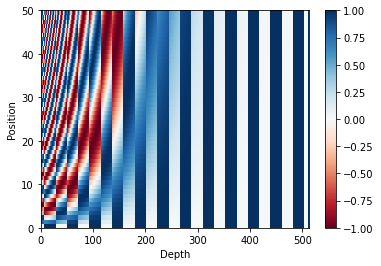

In [76]:
pos_encoding = positional_encoding(50, 512)
print(pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## 인코더

In [77]:
class EncoderLayer(tf.keras.layers.Layer):
    "positional encoding  더한 이후 block"
    
    def __init__(self, **kargs):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(**kargs)
        self.ffn = point_wise_feed_forward_network(**kargs)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(kargs['rate'])
        self.dropout2 = tf.keras.layers.Dropout(kargs['rate'])
    
    def call(self, x, mask):
        
        attn_output, _ = self.mha(x, x, x, mask) # (batch_size, seq_len, d_model)
        attn_output = self.dropout1(attn_output) 
        out1 = self.layernorm1(x + attn_output) # (batch_size, seq_len, d_model)
        
        ffn_output = self.ffn(out1) # (batch_size, seq_len, d_model)
        ffn_output = self.dropout2(ffn_output)
        out2 = self.layernorm2(out1 + ffn_output) # (batch_size, seq_len, d_model)
        
        return out2

class Encoder(tf.keras.layers.Layer):
    def __init__(self, **kargs):
        super(Encoder, self).__init__()

        self.d_model = kargs['d_model']
        self.num_layers = kargs['num_layers']

        self.embedding = tf.keras.layers.Embedding(kargs['input_vocab_size'], self.d_model)
        self.pos_encoding = positional_encoding(kargs['maximum_position_encoding'], 
                                                self.d_model)


        self.enc_layers = [EncoderLayer(**kargs) 
                           for _ in range(self.num_layers)]

        self.dropout = tf.keras.layers.Dropout(kargs['rate'])
        
    def call(self, x, mask):
        
        seq_len = tf.shape(x)[1]
        
        x = self.embedding(x)   # (batch_size, seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        
        x = self.dropout(x)
        
        # encoder block을 수회 반복한다. 
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, mask)
            
        return x # (batch_size, seq_len, d_model)
        

## 디코더

In [104]:

class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, **kargs):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(**kargs)  # self-attention
        self.mha2 = MultiHeadAttention(**kargs)  # cross-attention

        self.ffn = point_wise_feed_forward_network(**kargs)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(kargs['rate'])
        self.dropout2 = tf.keras.layers.Dropout(kargs['rate'])
        self.dropout3 = tf.keras.layers.Dropout(kargs['rate'])
    
    def call(self, x, enc_output, lookahead_mask, padding_mask):
        # enc_output: (batch_size, seq_len, d_model)
        
        attn1, attn_weights_block1 = self.mha1(x, x, x, lookahead_mask) # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1)
        out1 = self.layernorm1(attn1 + x)
        
        # attn2: (batch_size, target_seq_len, d_model)
        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2)
        out2 = self.layernorm2(attn2+out1)
        
        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2        
        
class Decoder(tf.keras.layers.Layer):
    def __init__(self, **kargs):
        super(Decoder, self).__init__()

        self.d_model = kargs['d_model']
        self.num_layers = kargs['num_layers']

        self.embedding = tf.keras.layers.Embedding(kargs['target_vocab_size'], self.d_model)
        self.pos_encoding = positional_encoding(kargs['maximum_position_encoding'], self.d_model)

        self.dec_layers = [DecoderLayer(**kargs) 
                           for _ in range(self.num_layers)]
        self.dropout = tf.keras.layers.Dropout(kargs['rate'])
        
    def call(self, x, enc_output, lookahead_mask, padding_mask):
    
        seq_len = tf.shape(x)[1]
        attention_weights = {}
        
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        
        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, lookahead_mask, padding_mask)
        
            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
        
        # x: (batch_size, target_seq_len, d_model)        
        return x, attention_weights

## 트랜스포머 모델

In [110]:
class Transformer(tf.keras.Model):
    def __init__(self, **kargs):
        super(Transformer, self).__init__(name=kargs['model_name'])
        self.end_token_idx = kargs['end_token_idx']
        
        self.encoder = Encoder(**kargs)
        self.decoder = Decoder(**kargs)

        self.final_layer = tf.keras.layers.Dense(kargs['target_vocab_size'])
        
    def call(self, x):
        inp, tar = x
        
        enc_padding_mask, lookahead_mask, dec_padding_mask = create_masks(inp, tar)
        enc_output = self.encoder(inp, enc_padding_mask)
        
        dec_output, _ = self.decoder(tar, enc_output, lookahead_mask, dec_padding_mask)
        
        final_output = self.final_layer(dec_output)
        
        return final_output
    
    def inference(self, x):
        inp = x
        tar = tf.expand_dims([STD_INDEX], 0)
        
        enc_padding_mask, lookahead_mask, dec_padding_mask = create_masks(inp, tar)
        enc_output = self.encoder(inp, enc_padding_mask)
        
        predict_tokens = list()
        for t in range(0, MAX_SEQUENCE):
            dec_output, _ = self.decoder(tar, enc_output, lookahead_mask, dec_padding_mask)
            final_output = self.final_layer(dec_output)
            
            outputs = tf.argmax(final_output, -1).numpy()
            pred_token = outputs[0][-1]
            if pred_token == self.end_token_idx:
                break
            predict_tokens.append(pred_token)
            
            tar = tf.expand_dims([STD_INDEX] + predict_tokens, 0)
            _, look_ahead_mask, dec_padding_mask = create_masks(inp, tar)
            
        return predict_tokens
            

## loss 정의

In [115]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')

def loss(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

def accuracy(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    mask = tf.expand_dims(tf.cast(mask, dtype=pred.dtype), axis=-1)
    pred *= mask    
    acc = train_accuracy(real, pred)

    return tf.reduce_mean(acc)

In [116]:
model = Transformer(**kargs)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss=loss,
              metrics=[accuracy])

## Callback 선언

In [117]:
# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=10)
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)

checkpoint_path = DATA_OUT_PATH + model_name + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    

cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

./train_out/transformer -- Folder already exists 



In [119]:
EPOCHS = 30
MAX_DATA = 100
history = model.fit([index_inputs[:MAX_DATA], index_outputs[:MAX_DATA]], index_targets[:MAX_DATA], 
                    batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_split=VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])

Epoch 1/30
45/45 [==============================] - ETA: 0s - loss: 1.4505 - accuracy: 0.8529
Epoch 00001: val_accuracy improved from -inf to 0.85180, saving model to ./train_out/transformer/weights.h5
45/45 [==============================] - 5s 118ms/step - loss: 1.4505 - accuracy: 0.8529 - val_loss: 1.1900 - val_accuracy: 0.8518
Epoch 2/30
45/45 [==============================] - ETA: 0s - loss: 1.2069 - accuracy: 0.8515
Epoch 00002: val_accuracy did not improve from 0.85180
45/45 [==============================] - 5s 102ms/step - loss: 1.2069 - accuracy: 0.8515 - val_loss: 1.1792 - val_accuracy: 0.8512
Epoch 3/30
45/45 [==============================] - ETA: 0s - loss: 1.0004 - accuracy: 0.8515
Epoch 00003: val_accuracy did not improve from 0.85180
45/45 [==============================] - 5s 104ms/step - loss: 1.0004 - accuracy: 0.8515 - val_loss: 1.2051 - val_accuracy: 0.8509
Epoch 4/30
45/45 [==============================] - ETA: 0s - loss: 0.8438 - accuracy: 0.8521
Epoch 00004: 

Epoch 26/30
45/45 [==============================] - ETA: 0s - loss: 0.0225 - accuracy: 0.9429
Epoch 00026: val_accuracy improved from 0.94209 to 0.94373, saving model to ./train_out/transformer/weights.h5
45/45 [==============================] - 5s 115ms/step - loss: 0.0225 - accuracy: 0.9429 - val_loss: 1.4249 - val_accuracy: 0.9437
Epoch 27/30
45/45 [==============================] - ETA: 0s - loss: 0.0200 - accuracy: 0.9445
Epoch 00027: val_accuracy improved from 0.94373 to 0.94525, saving model to ./train_out/transformer/weights.h5
45/45 [==============================] - 5s 114ms/step - loss: 0.0200 - accuracy: 0.9445 - val_loss: 1.4332 - val_accuracy: 0.9453
Epoch 28/30
45/45 [==============================] - ETA: 0s - loss: 0.0178 - accuracy: 0.9460
Epoch 00028: val_accuracy improved from 0.94525 to 0.94668, saving model to ./train_out/transformer/weights.h5
45/45 [==============================] - 5s 115ms/step - loss: 0.0178 - accuracy: 0.9460 - val_loss: 1.4310 - val_accura

In [121]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

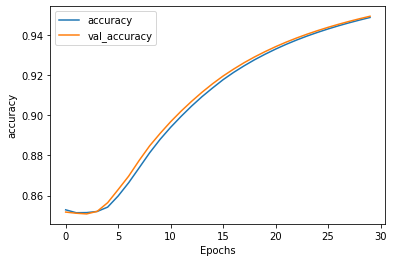

In [122]:
plot_graphs(history, 'accuracy')

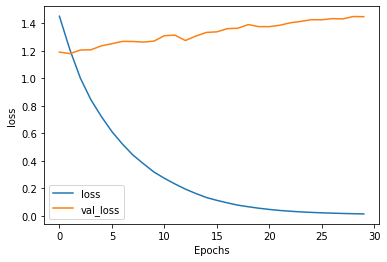

In [123]:
plot_graphs(history, 'loss')